<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/balaced_data/Copy_of_content_based_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# %%
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy

In [67]:
# load the data
dsc_up_df = pd.read_csv(
    r'/content/dsc_up.csv')
car_dict_df = pd.read_csv(
    r'/content/car_dict.csv')

dsc_up_df = dsc_up_df.replace({np.NaN: 0})
car_dict_df = car_dict_df.replace({np.NaN: 0})

dsc_up = dsc_up_df.values
car_dict = car_dict_df.values

print(dsc_up.shape)
print(car_dict.shape)

(13765, 33)
(119, 83)


In [68]:
num_cars = len(car_dict)
print(num_cars)

119


In [69]:
# balance samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[dsc_up[:, 31] == i]) > 400:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[dsc_up[:, 31] == i])), size=400, replace=False)
    dsc_up_bali = dsc_up[dsc_up[:, 31] == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[dsc_up[:, 31] == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(9492, 33)


In [70]:
# load the label
print(car_dict.shape)
print(dsc_up.shape)

ys_up = dsc_up[:, 31]
print(ys_up)

(119, 83)
(9492, 33)
[0 0 0 ... 118 118 118]


In [71]:
# transfer the label to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(ys.shape)

(9492, 119)


In [72]:
# column of last feature from 0 and +1
col_last_feature_car = 80
# 80
    #76
col_last_feature_user = 28
car_unscaled = car_dict[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]

# generate the gaussian random no. to budget feature
mu_budget = 0
sigma_budget = 1.5
for i in range(len(user_unscaled)):
    user_unscaled[i, 23] += random.gauss(mu_budget, sigma_budget)

scalerCar = StandardScaler()
scalerCar.fit(car_dict[:, 1:col_last_feature_car])
car = scalerCar.transform(car_dict[:, 1:col_last_feature_car])

scalerUser = StandardScaler()
scalerUser.fit(dsc_up[:, 1:col_last_feature_user])
user = scalerUser.transform(dsc_up[:, 1:col_last_feature_user])

print(np.allclose(car_unscaled.astype(float), scalerCar.inverse_transform(car)))
print(np.allclose(user_unscaled.astype(float), scalerUser.inverse_transform(user)))

True
True


In [73]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

In [74]:
# pca analysis
pca_25 = PCA(n_components=25)
print(pca_25)
pca_25.fit(user)
print(pca_25.explained_variance_ratio_)

# %%
pca_30 = PCA(n_components=2)
print(pca_30)
pca_30.fit(car_dict[:, 1:15])
print(pca_30.explained_variance_ratio_)
c_trans = pca_30.transform(car_dict[:, 1:15])
# plt.plot(c_trans[:, 0], c_trans[:, 1], 'ro')


PCA(n_components=25)
[0.07796035 0.06409342 0.05633797 0.05227742 0.04880957 0.04271682
 0.04063733 0.03915272 0.03844287 0.03760948 0.03719759 0.03606643
 0.03594489 0.03526003 0.03469709 0.03385688 0.03347204 0.03251125
 0.03182496 0.03176907 0.03059699 0.02984124 0.02775645 0.02594709
 0.02514134]
PCA(n_components=2)
[0.79305611 0.14624711]


In [75]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))

ys = ys.reshape(-1, 1)
print(user_vecs.shape)
print(car_vecs.shape)
print(ys.shape)

(1129548, 27)
(1129548, 79)
(1129548, 1)


In [76]:
ys[ys == 0].shape

(1120056,)

In [12]:
# # case 2
# car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
# user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
# ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

# car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
# user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
# ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [77]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

29


In [14]:
# # case 2
# user_train_one = user_train[(ys_train == 1)[:, 0]]
# user_train_one = gen_car_vecs(user_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# user_train_zero = user_train[(ys_train == 0)[:, 0]]
# user_train = np.concatenate((user_train_zero, user_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(user_train)
# print(user_train.shape)

In [15]:
# # case 2
# car_train_one = car_train[(ys_train == 1)[:, 0]]
# car_train_one = gen_car_vecs(car_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# car_train_zero = car_train[(ys_train == 0)[:, 0]]
# car_train = np.concatenate((car_train_zero, car_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(car_train)
# print(car_train.shape)

In [16]:
# # case 2
# ys_one = ys_train[(ys_train == 1)[:, 0]]
# ys_one = gen_car_vecs(ys_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# ys_zero = ys_train[(ys_train == 0)[:, 0]]
# ys_train = np.concatenate((ys_zero, ys_one), axis=0)
# random.seed(randnum)
# random.shuffle(ys_train)
# print(ys_train.shape)

In [17]:
# user_vecs_one = user_vecs[(ys == 1)[:, 0]]

In [18]:
# num_users = user_vecs_one.shape[0]
# print(num_users)


In [19]:
# user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
# num_zeros = user_vecs_zero.shape[0]
# print(num_zeros)

In [20]:
# random.seed(randnum)

In [21]:
# sample_row = np.random.choice(np.arange(num_zeros), size=num_users, replace=False)

In [22]:
# sample_row

In [23]:
# user_vecs_zero = user_vecs_zero[sample_row]
# print(user_vecs_zero.shape)

In [78]:
# case 3
user_vecs_one = user_vecs[(ys == 1)[:, 0]]
# user_vecs_one = gen_car_vecs(user_vecs_one, len(car_dict)-1)
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.2).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(user_vecs.shape)

(20883, 27)


In [79]:
# case3
car_vecs_one = car_vecs[(ys == 1)[:, 0]]
# car_vecs_one = gen_car_vecs(car_vecs_one, len(car_dict)-1)

car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(car_vecs.shape)

(20883, 79)


In [80]:
# case 3
ys_one = ys[(ys == 1)[:, 0]]
# ys_one = gen_car_vecs(ys_one, len(car_dict)-1)

ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(ys.shape)

(20883, 1)


In [81]:
# case 3
car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [82]:
print(f"cars training data shape:{car_train.shape}")
print(f"cars validating data shape:{car_val.shape}")
print(f"cars testing data shape:{car_test.shape}")

print(f"users training data shape:{user_train.shape}")
print(f"users validating data shape:{user_val.shape}")
print(f"users testing data shape:{user_test.shape}")

print(f"ys training data shape:{ys_train.shape}")
print(f"ys validating data shape:{ys_val.shape}")
print(f"ys testing data shape:{ys_test.shape}")

cars training data shape:(16706, 79)
cars validating data shape:(2088, 79)
cars testing data shape:(2089, 79)
users training data shape:(16706, 27)
users validating data shape:(2088, 27)
users testing data shape:(2089, 27)
ys training data shape:(16706, 1)
ys validating data shape:(2088, 1)
ys testing data shape:(2089, 1)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 27)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 79)]         0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 32)           44192       ['input_3[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 32)           57504       ['input_4[0][0]']                
                                                                                            

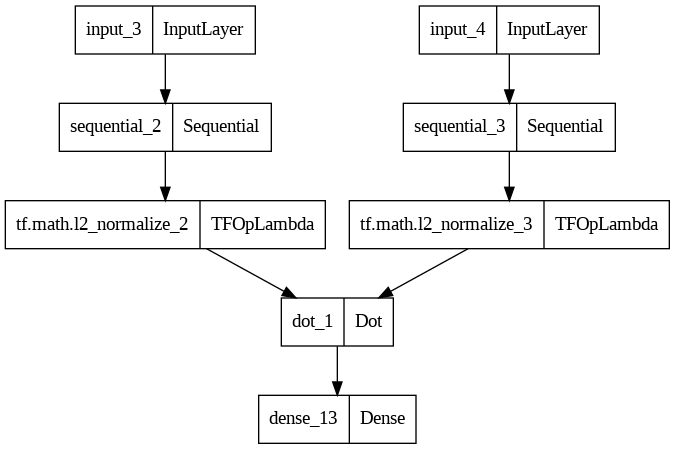

In [83]:
num_user_features = col_last_feature_user-1
num_car_features = col_last_feature_car-1
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])
car_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_car = tf.keras.layers.Input(shape=(num_car_features))
vc = car_NN(input_car)
vc = tf.linalg.l2_normalize(vc, axis=1)

d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

model = tf.keras.Model([input_user, input_car], output)
model.summary()
tf.keras.utils.plot_model(model, "/content/my_model.png")

In [84]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [85]:
tf.random.set_seed(1)
model.fit([user_train, car_train], ys_train, epochs=5)

Epoch 1/5
523/523 [==============================] - 4s 4ms/step - loss: 0.1751
Epoch 2/5
523/523 [==============================] - 3s 5ms/step - loss: 0.1353
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 0.1249
Epoch 4/5
523/523 [==============================] - 2s 4ms/step - loss: 0.1136
Epoch 5/5
523/523 [==============================] - 2s 4ms/step - loss: 0.1067


In [86]:
model.evaluate([user_val, car_val], ys_val)

66/66 [==============================] - 0s 2ms/step - loss: 0.1022


0.10219211131334305

In [87]:
model.evaluate([user_val[(ys_val == 0)[:, 0]], car_val[(ys_val == 0)[:, 0]]], ys_val[(ys_val == 0)[:, 0]])
model.evaluate([user_val[(ys_val == 1)[:, 0]], car_val[(ys_val == 1)[:, 0]]], ys_val[(ys_val == 1)[:, 0]])

30/30 [==============================] - 0s 4ms/step - loss: 0.0976


0.09757809340953827

In [88]:
ys_test.shape

(2089, 1)

In [89]:
model.evaluate([user_test[(ys_test == 0)[:, 0]], car_test[(ys_test == 0)[:, 0]]], ys_test[(ys_test == 0)[:, 0]])
model.evaluate([user_test[(ys_test == 1)[:, 0]], car_test[(ys_test == 1)[:, 0]]], ys_test[(ys_test == 1)[:, 0]])

29/29 [==============================] - 0s 2ms/step - loss: 0.0869


0.08694513887166977

In [90]:
ys_p_test = model.predict([[user_test, car_test]])
ys_p_test_vs = np.concatenate((ys_p_test, ys_test), axis=1)
ys_test_df = pd.DataFrame(ys_p_test_vs)
ys_test_df.to_csv(r'/content/ys_p_test_6epoch.csv', encoding='UTF-8')

66/66 [==============================] - 0s 2ms/step


In [91]:
# print the confusion matrix & report
print(confusion_matrix(ys_test, np.round(ys_p_test)))
print(classification_report(ys_test, np.round(ys_p_test)))

[[967 194]
 [ 82 846]]
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.88      1161
         1.0       0.81      0.91      0.86       928

    accuracy                           0.87      2089
   macro avg       0.87      0.87      0.87      2089
weighted avg       0.87      0.87      0.87      2089



AUC: 0.9222898846119576


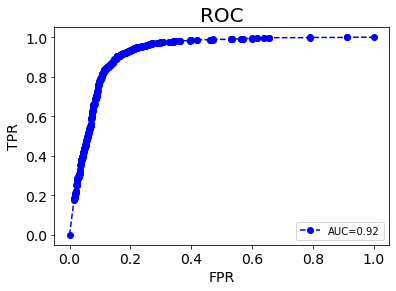

In [92]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_test, ys_p_test)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='Arial Unicode MS', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

In [93]:
ys_p_train = model.predict([[user_train, car_train]])

523/523 [==============================] - 1s 2ms/step


In [94]:
# print the confusion matrix & report
print(confusion_matrix(ys_train, np.round(ys_p_train)))
print(classification_report(ys_train, np.round(ys_p_train)))

[[7584 1499]
 [ 755 6868]]
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87      9083
         1.0       0.82      0.90      0.86      7623

    accuracy                           0.87     16706
   macro avg       0.87      0.87      0.86     16706
weighted avg       0.87      0.87      0.87     16706



基于某个用户，预测不同的车的购买倾向

In [95]:
list = []
for i in range(len(dsc_up)):
  if dsc_up[i, 31] == 56:
    list.append(i)
print(list)

[4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 510

In [ ]:
# predict the new car of new performance for specific user
# define the cars and the user
row_car_dict = np.arange(0, num_cars) 
row_user_dst = [4951]
new_car = car_unscaled[row_car_dict]
new_user = gen_car_vecs(user_unscaled[row_user_dst], len(row_car_dict))

# predict the new car of new performance
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])
print(f'target car is {dsc_up[row_user_dst, 32]}, car No. is {dsc_up[row_user_dst, 31]}')
for i in range(len(row_car_dict)):
    print(
        f'{i} :'
        f'{car_dict[row_car_dict, 81].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [116]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[row_car_dict == dsc_up[row_user_dst, 31]] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))


[[115   3]
 [  0   1]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       118
         1.0       0.25      1.00      0.40         1

    accuracy                           0.97       119
   macro avg       0.62      0.99      0.69       119
weighted avg       0.99      0.97      0.98       119



In [102]:
dsc_up[row_user_dst, 31]

array([56], dtype=object)

In [103]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_car_predict_vs.csv', encoding='UTF-8')

基于某款车预测不同用户的购买倾向

In [ ]:
row_car_dict = [56]
row_user_dst = np.arange(0, num_users)
new_car = gen_car_vecs(car_unscaled[row_car_dict], len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 200)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [193]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[dsc_up[row_user_dst, 31] == row_car_dict] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))

[[6646 2678]
 [  50  118]]
              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83      9324
         1.0       0.04      0.70      0.08       168

    accuracy                           0.71      9492
   macro avg       0.52      0.71      0.45      9492
weighted avg       0.98      0.71      0.82      9492



In [195]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_vs = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_user_predict_vs3.csv', encoding='UTF-8')

In [197]:
new_y_predict [new_car_predict > 0.8].shape

(2796,)

修改某款车性能参数，预测不同用户的购买倾向

In [199]:
# 32 宋DMIDMI110km
# 56 低配影酷
car_unscaled[56, 0]

11.98

In [200]:
# base car parameters
row_car_dict = [56]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
print(new_car_one)

[[11.98 7 1 2 1 0.0 0.0 130 270 1 190 8.35 0 735 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [203]:
# modify the paramters of some car
new_car_one[:, 0:14] = car_unscaled[32, 0:14]
print(new_car_one)

[[17.58 4 1 3 3 0.7 5.5 81 135 1 170 7.9 110 1443 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [206]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify.csv', encoding='UTF-8')

In [208]:
new_y_predict [new_car_predict > 0.8].shape

(3179,)

In [209]:
dsc_up.shape

(9492, 33)

修改用户地点，预测用户购买某款车的倾向变化

In [181]:
row_car_dict = [11]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

In [182]:
# modify the place of users
# 吉林：26 长春：295
# 广东：1 广州：115
# 广东：1 深圳：195
new_user[:, (22,24)] = [(115, 1)]
print(new_user[0:10,(22,24)])

[[115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]]


In [168]:
new_user[0]

array([3, 3, 2, 3, 2, 3, 3, 3, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 100, 295, 12.098126670453805, 26, 0, 7],
      dtype=object)

In [ ]:
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [184]:
threshold_p = 0.23
new_y_predict [new_car_predict > threshold_p].shape

(719,)

In [178]:
num_users

9492

In [185]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > threshold_p] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_place.csv', encoding='UTF-8')

**others：**

In [56]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 30].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict3.csv', encoding='UTF-8')

In [57]:
a = np.array([0,1,2])
b = np.array([1,2,3])
print(np.dot(a,b))

8
